In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import jax.numpy as jnp
import numpy as np
import os
from matplotlib import pyplot as plt

import sys
sys.path.append('../')
import field_level.inference as inference

!nvidia-smi --query-gpu=gpu_name --format=csv,noheader

/home/kakitsu/field_level/field_level/examples/../field_level/inference.py:37: SyntaxWarning: invalid escape sequence '\d'
  """


NVIDIA H200
NVIDIA H200
NVIDIA H200
NVIDIA H200
NVIDIA H200
NVIDIA H200
NVIDIA H200
NVIDIA H200


The inference is running on gpu
/opt/sns/anaconda3/2024.06/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


### Example of the field-level inference for the linear Gaussian field with $64^3$ ICs in 2.0 $\mathrm{Gpc}/h$ box and $k_\mathrm{max}=0.1~h/\mathrm{Mpc}$

In [7]:
### parameters

boxsize = 2000.0
redshift = 0.5
which_pk = 'cosmo'

data_path = f'../mock_data/{which_pk}_{boxsize}_z{redshift}_gauss_8.0_128.npy'
save_path = './results/gauss'
if not os.path.exists('./results'):
    os.mkdir('./results')

ics_params = ['varied_ics', 0] 
### 0 specifies not saving the samples of modes, if you set 1 the samples of modes are also saved (but be careful that its size would be huge).

model_name = 'gauss'

ng_params = [64, 64, 128] 
### the number of ICs, the number of particles, and the number of assignment grid (the last twos are not relevant for gaussian case)

mas_params = [2, 1]
### the interpolation order of assignment, and the interlace or not. Again, this is not relevant for the gaussian run

which_space = 'k_space'
### In which space the likelihood is evaluated. Now only 'k_space' is suppoerted

cosmo_params = {'A':1.0, 'oc': 0.11933, 'hubble': 0.73}
#cosmo_params = {'sigma8':0.835, 'oc': 0.11933, 'hubble': 0.73}

bias_params = {}

err_params = {'fixed_log_Perr':8.0}
### for the fixed value of the noise in the likelihood. If you would like to vary it, set 'log_Perr':8.0.

kmax = 0.1

dense_mass = [('A', 'scaled_oc', 'scaled_hubble')]
#dense_mass = [('sigma8', 'oc', 'hubble')]

mcmc_params = [0, 4, 1, 10000, 1000, 0.8, 2004, 0]
### i-th chain, the number of chains, thinning, the number of samples, the number of warmup, the target acceptance rate, random seed for mcmc, and the number of the previously collected samples divied by 100 (to restart)



In [8]:
### run inferencne

inference.field_inference(boxsize, redshift, which_pk,
                          data_path, save_path,
                          ics_params,
                          model_name, ng_params, mas_params, which_space,
                          cosmo_params, bias_params, err_params, kmax,
                          dense_mass, mcmc_params)

varied_ics
fixed_log_Perr =  8.0
cic interlacing on
ng =  64
ng_L =  64
ng_E =  128
kmax =  0.1
model =  gauss
idx_conjugate_real_kmax.shape =  (67647,)
idx_conjugate_imag_kmax.shape =  (67647,)
Loading the data from ../mock_data/cosmo_2000.0_z0.5_gauss_8.0_128.npy...
Done.
data_1d_ind.shape = 
(135042,)


dense_mass =  [('A', 'scaled_oc', 'scaled_hubble')]
params =  ['A', 'H0', 'OM', 'hubble', 'oc', 'scaled_hubble', 'scaled_oc', 'sigma8', 'potential_energy']
min_pe_params =  ['A', 'H0', 'OM', 'gauss_1d', 'hubble', 'oc', 'scaled_hubble', 'scaled_oc', 'sigma8', 'potential_energy']
save_base =  ./results/gauss
rng_seed =  2004
post_warmup_state = 
HMCState(i=Array([1000, 1000, 1000, 1000], dtype=int32), z={'A': Array([ 0.0460467 , -0.08410902,  0.1246013 , -0.05168832], dtype=float32), 'gauss_1d': Array([[ 0.40268794, -0.7014584 , -1.1581923 , ..., -1.4508088 ,
        -0.16617143,  1.67674   ],
       [ 0.95539904, -0.11186166, -2.0342445 , ..., -0.19742253,
         0.28616813,  0.9748132 ],
       [ 1.541234  ,  1.3934312 ,  0.09111219, ...,  0.41381997,
         0.31400484,  1.515696  ],
       [ 0.09143209, -0.81936973, -1.2596062 , ..., -1.1522619 ,
        -0.97715694,  2.0500088 ]], dtype=float32), 'scaled_hubble': Array([-0.18654986,  0.39497995, -0.48928568,  0.2619077 ], dtype=f

In [13]:
### load samples

params = []

params += cosmo_params.keys()

if 'A' in cosmo_params.keys():
    params += ['sigma8']
if 'sigma8' in cosmo_params.keys():
    params += ['A']
if 'hubble' in cosmo_params.keys():
    params += ['H0']
if 'hubble' in cosmo_params.keys() or 'oc' in cosmo_params.keys():
    params += ['OM']

params += bias_params.keys()

if 'fixed_log_Perr' in err_params.keys():
    fixed_log_Perr = err_params.pop('fixed_log_Perr')
    print('fixed_log_Perr = ', fixed_log_Perr, file=sys.stderr)
else:
    params += err_params.keys()


samples = {}
i_chain = mcmc_params[0]
for param in params:
    tmp = []
    for i_chain in range(mcmc_params[1]):
        tmp.append(np.loadtxt(save_path + f'_{param}_chain{i_chain}.dat'))
    samples[param] = np.array(tmp)


array([[<Axes: title={'center': 'A'}>, <Axes: title={'center': 'A'}>],
       [<Axes: title={'center': 'oc'}>, <Axes: title={'center': 'oc'}>],
       [<Axes: title={'center': 'hubble'}>,
        <Axes: title={'center': 'hubble'}>],
       [<Axes: title={'center': 'sigma8'}>,
        <Axes: title={'center': 'sigma8'}>],
       [<Axes: title={'center': 'H0'}>, <Axes: title={'center': 'H0'}>],
       [<Axes: title={'center': 'OM'}>, <Axes: title={'center': 'OM'}>]],
      dtype=object)

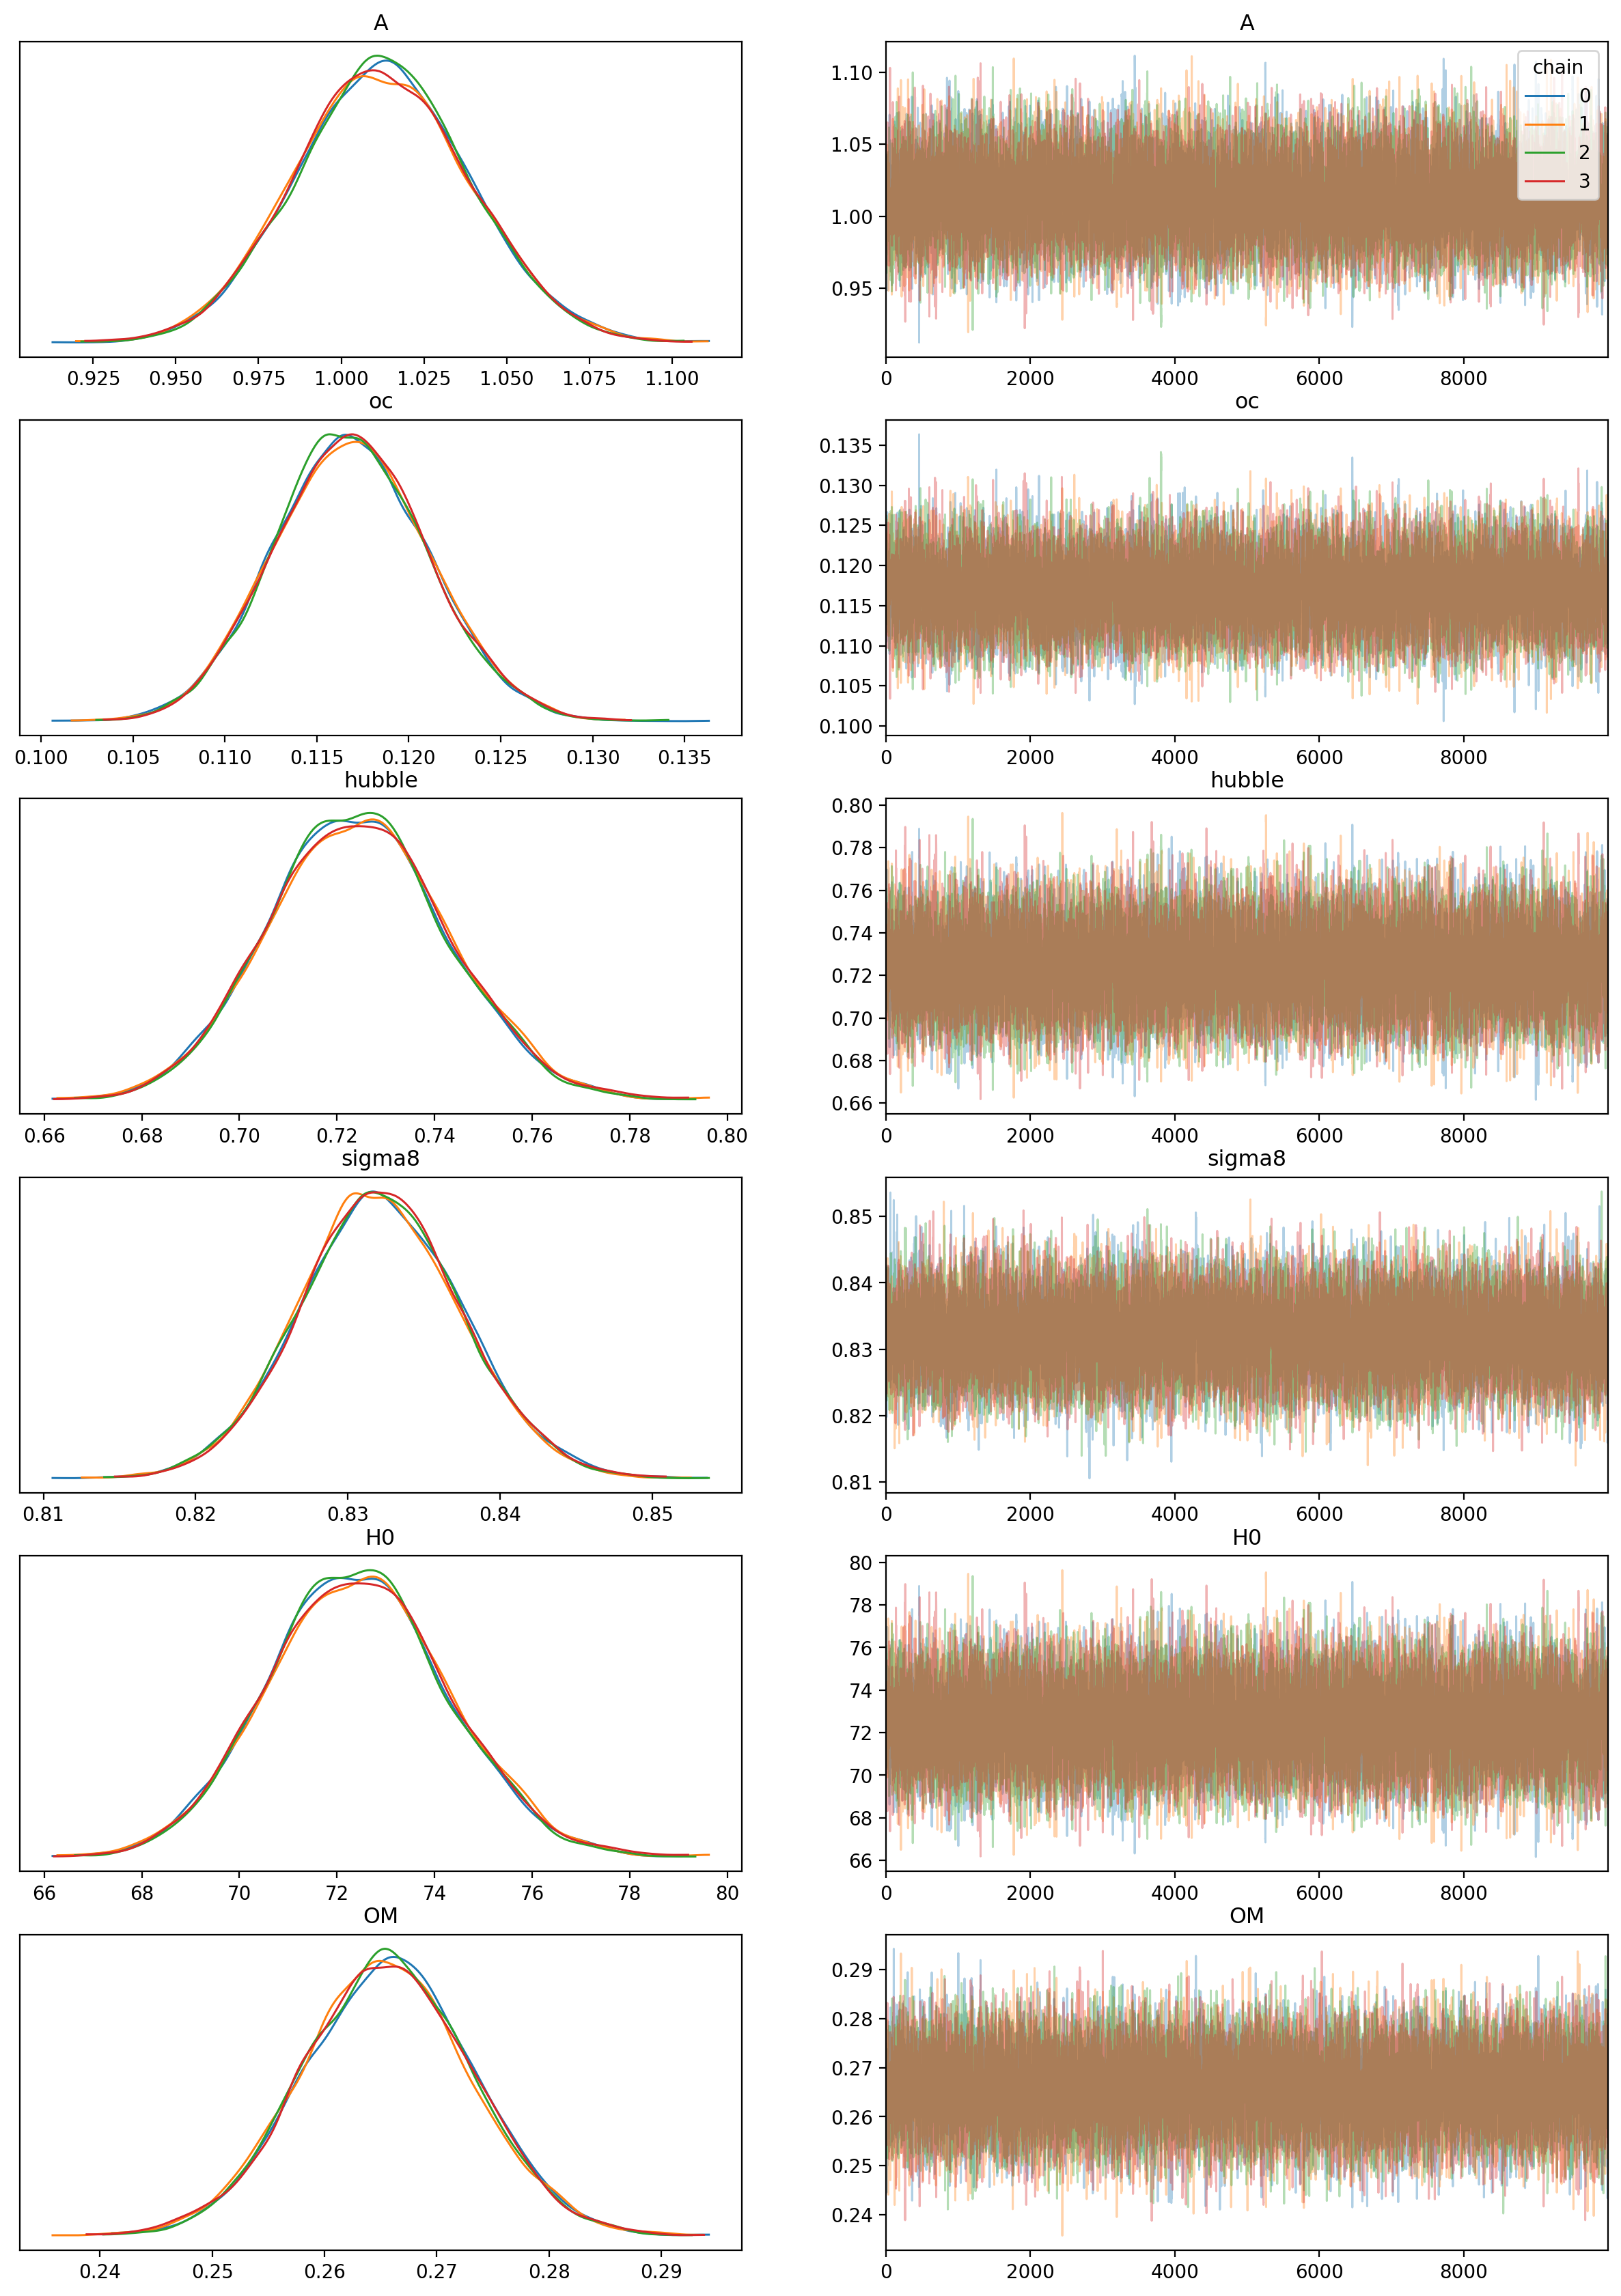

In [16]:
import arviz as az

az.plot_trace(samples, legend=True, compact=False, figsize=(15,3.5*len(samples)))

In [17]:
az.summary(samples,
           var_names=params,
           round_to=10,
           coords={'chain':[0,1,2,3]})

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
A,1.012562,0.026227,0.963955,1.062260,0.000225,0.000159,13514.598218,20686.395454,1.000148
oc,0.116866,0.004183,0.109041,0.124720,0.000037,0.000026,12847.725956,20781.272783,1.000052
hubble,0.724404,0.018342,0.691195,0.759866,0.000154,0.000109,14181.940305,20466.569639,1.000132
sigma8,0.832146,0.005315,0.822294,0.842399,0.000043,0.000031,15005.030577,23203.664136,1.000505
H0,72.440399,1.834181,69.119507,75.986580,0.015424,0.010919,14181.939396,20466.569639,1.000132
OM,0.265585,0.007537,0.251306,0.279659,0.000061,0.000043,15492.293571,21362.795399,1.000354


In [24]:
### show posterior contour

from getdist import plots, MCSamples
import getdist

contour_params = ['A', 'oc', 'H0']

labels = ['A', '\omega_\mathrm{cdm}', 'H_0']

samples_ = []
for contour_param in contour_params:
    tmp = samples[contour_param]
    if tmp.ndim == 1:
        samples_ += [tmp]
    elif tmp.ndim == 2:
        tmp = tmp.reshape(-1)
        samples_ += [tmp]
    
plot_samples = MCSamples(samples=samples_, 
                         names = contour_params,
                         labels = labels)

Removed no burn in


<>:8: SyntaxWarning: invalid escape sequence '\o'
<>:8: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_2279558/2955857986.py:8: SyntaxWarning: invalid escape sequence '\o'
  labels = ['A', '\omega_\mathrm{cdm}', 'H_0']


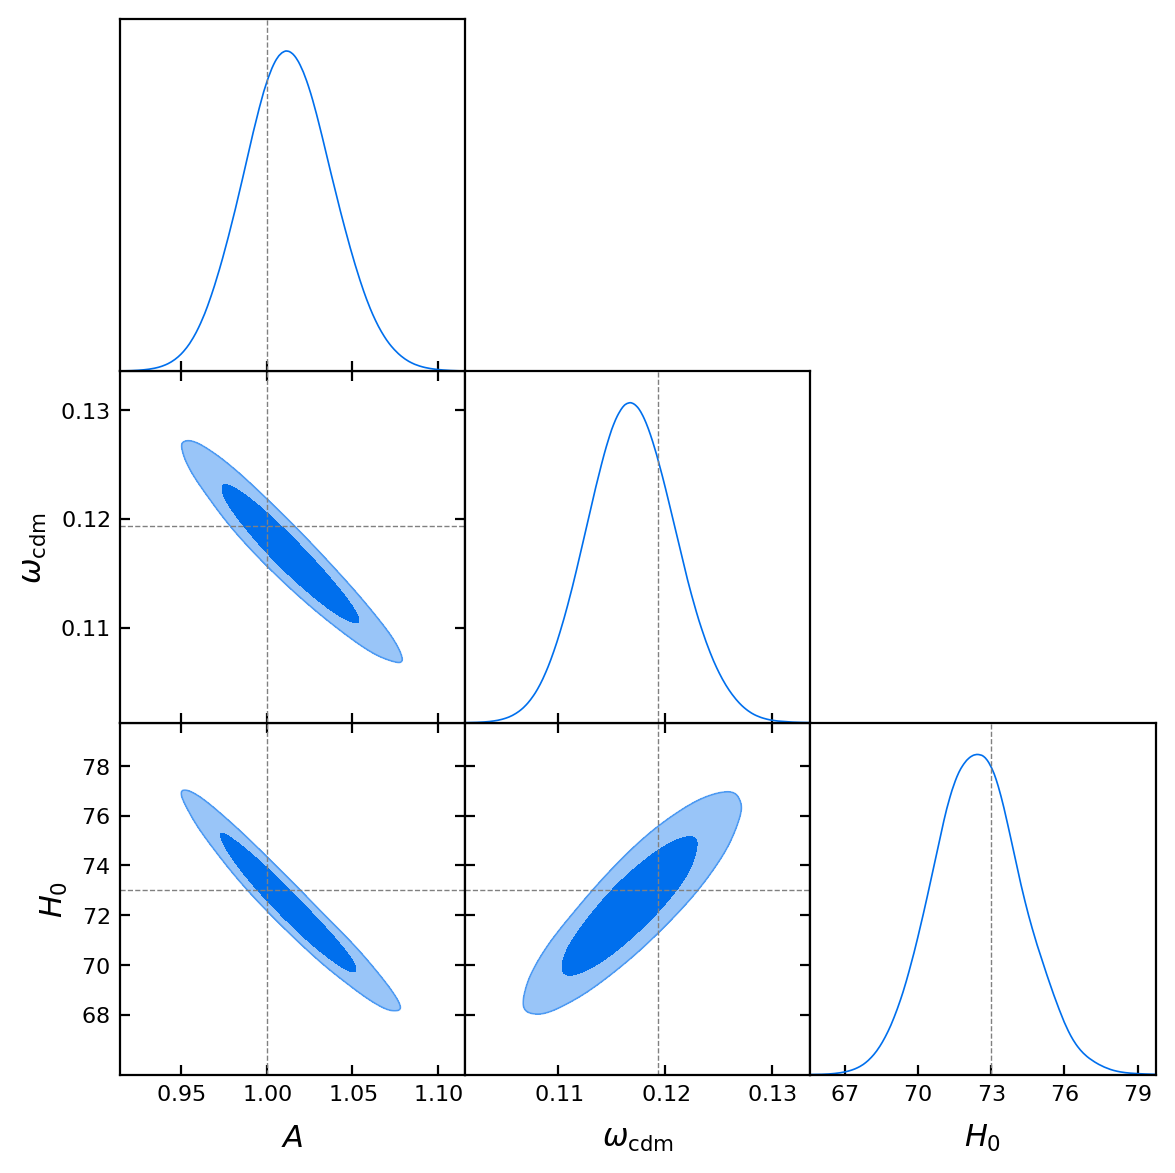

In [25]:
%matplotlib inline

g = plots.get_subplot_plotter()
g.triangle_plot([plot_samples], 
                filled=True,
                markers={'A':1.0, 'sigma8':0.835, 'oc': 0.11933, 'H0':73.0})